In [239]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import math

# Data cleaning and Pre-processing 

In [240]:
#header creation and directory paths

usage_dir = "task_usage/"
job_dir = "job_events/"

task_usage_header = ['start_time','end_time','job_id','task_index','machine_id', 'mean_cpu_usage',
                     'canon_memory_usage', 'assign_memory_usage', 'unmapped_cache', 'total_cache', 
                     'max_mem', 'mean_io', 'mean_space', 'max_cpu', 'max_io', 'cpi', 'mai', 'sample',
                     'agg_type', 'sample_cpu_usage']

job_header = ['timestamp','missing_info', 'job_id', 'event_type', 'user_name', 'scheduling_class',
              'job_name','logical_job_name']

In [241]:
#read csv - drop unused columns

final_df = pd.DataFrame()

# 3 files used for each category
for i in range(3):
    file_str = str(i).zfill(5)
    usage_df = pd.read_csv(usage_dir +"part-"+file_str+"-of-00500.csv.gz",header=None)
    usage_df.columns = task_usage_header

    job_df = pd.read_csv(job_dir +"part-"+file_str+"-of-00500.csv.gz",header=None)
    job_df.columns = job_header

    job_df.drop(['missing_info','user_name', 'scheduling_class',
                  'job_name','logical_job_name'], axis =1,inplace=True)

    usage_df.drop(['task_index','machine_id','canon_memory_usage', 'assign_memory_usage', 'unmapped_cache', 'total_cache', 
                         'max_mem', 'mean_io', 'mean_space', 'max_cpu', 'max_io', 'cpi', 'mai', 'sample',
                         'agg_type', 'sample_cpu_usage'], axis =1,inplace=True)

    #merge to filter jobs with valid life - SCHEDULE to FINISH

    new_jobdf = pd.merge(job_df[(job_df['event_type'] == 1)],job_df[ (job_df['event_type'] == 4)], on = "job_id")
    new_jobdf.drop(['event_type_x',  'event_type_y'], axis =1,inplace=True)
    new_jobdf['life_time'] = new_jobdf['timestamp_y'] -  new_jobdf['timestamp_x']
    new_jobdf.drop(['timestamp_x',  'timestamp_y'], axis =1,inplace=True)
    #new_jobdf
    
    
    #merge to get cpu usage of jobs with valid lifetime

    n_jobdf = pd.merge(usage_df,new_jobdf, on = "job_id")
    n_jobdf['start_time'] = (n_jobdf['start_time']/1000000)
    n_jobdf['end_time'] = (n_jobdf['end_time']/1000000)
    n_jobdf['life_time'] = (n_jobdf['life_time']/1000000)

    # arrange cpu uses by jobs- add parallel cpu uses of all tasks of a jobs during a time cycle
    
    final_df = final_df.append(n_jobdf.groupby(['job_id','start_time','end_time']).sum())
final_df


In [242]:
final_df.reset_index(level='start_time',inplace=True)
final_df.reset_index(level='end_time',inplace=True)

,end_time,start_time,mean_cpu_usage,life_time
job_id,,,,
6245463804,900.0,600.0,0.000050,3452.681356
6245463804,1200.0,900.0,0.000050,3452.681356
6245463804,1500.0,1200.0,0.000050,3452.681356
6245463804,1800.0,1500.0,0.000052,3452.681356
6245463804,2100.0,1800.0,0.000045,3452.681356
6245463804,2400.0,2100.0,0.000045,3452.681356
6245463804,2700.0,2400.0,0.000048,3452.681356
6245463804,3000.0,2700.0,0.000053,3452.681356
6245463804,3300.0,3000.0,0.001850,3452.681356


# Data normalization and Binning

In [ ]:
#normalising the mean cpu usage - y axis
# print(final_df.index.get_level_values(0).unique())
# for i in final_df.index.get_level_values(0).unique():


for i in final_df.index.get_level_values(0).unique():
    minn = final_df.loc[i]['mean_cpu_usage'].min()
    maxx = final_df.loc[i]['mean_cpu_usage'].max() 
    # print(minn,maxx)
    small_df = final_df[final_df.index == i]
    small_df['mean_cpu_usage'] = (small_df['mean_cpu_usage'] - minn)/(maxx-minn)
    final_df[final_df.index == i] = small_df
final_df

# Sample Distribution Plots

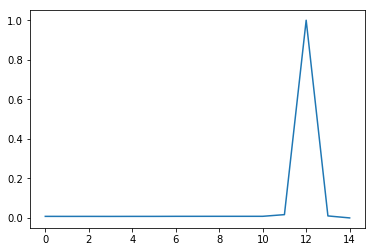

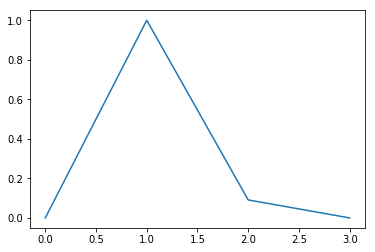

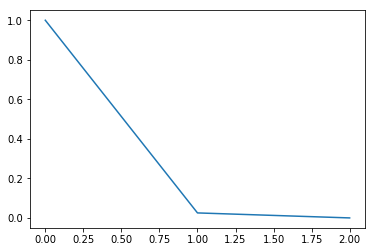

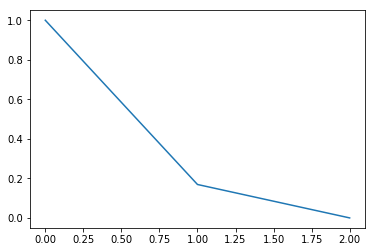

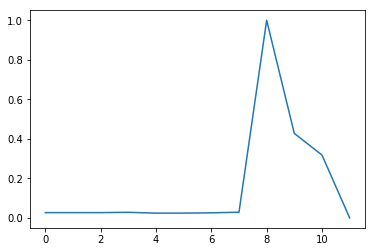

In [244]:
#5 plots of random jobs and their cpu usages

small_df = final_df[final_df.index == 6248941479]
colVals = small_df['mean_cpu_usage'].tolist()
plt.plot(colVals)
plt.show()

small_df = final_df[final_df.index == 6252015953]
colVals = small_df['mean_cpu_usage'].tolist()
plt.plot(colVals)
plt.show()

small_df = final_df[final_df.index == 6252014624]
colVals = small_df['mean_cpu_usage'].tolist()
plt.plot(colVals)
plt.show()

small_df = final_df[final_df.index == 6252018909]
colVals = small_df['mean_cpu_usage'].tolist()
plt.plot(colVals)
plt.show()

small_df = final_df[final_df.index == 6245463804]
colVals = small_df['mean_cpu_usage'].tolist()
plt.plot(colVals)
plt.show()


In [245]:
#function to calculate values in each bin of each job's cpu uasge distribution

def calc_point(x1,y1,x2,y2,point):
    y=(point-x1)*(y2-y1)/(x2-x1)+y1
    if math.isnan(y):
        return -1000
    return y
def calculateValues(dataframe):
    my_points=[]
    start_index = 0
    next_index=1
    row0 = dataframe.iloc[start_index]
    row1 = dataframe.iloc[next_index]
    point = row0.end_time
    x1= row0.end_time
    x2= row1.end_time
    y1= row0.mean_cpu_usage
    y2= row1.mean_cpu_usage
    end_point = dataframe.iloc[dataframe.shape[0]-1].end_time
    my_points.append(y1)
#     print(point)
#     print(end_point)
    bin_size = (end_point-point)/100
#     print(bin_size)
    for i in range(100):
        point = point + bin_size
        if point > x2:
            start_index += 1
            next_index += 1
            if next_index >= dataframe.shape[0]:
                return my_points
            row0 = dataframe.iloc[start_index]
            row1 = dataframe.iloc[next_index]
            point = row0.end_time
            x1= row0.end_time
            x2= row1.end_time
            y1= row0.mean_cpu_usage
            y2= row1.mean_cpu_usage
#         print(point)
        val = calc_point(x1,y1,x2,y2,point)
        if val == -1000:
            return [-1000]
        my_points.append(val)
#     print(len(my_points))
    my_points.append(0)
    return my_points

In [246]:
#divide each lifetime into 100 bins
#get vector of all job's common usage distribution

# dummy = final_df.reset_index(level='start_time')
# dummy.reset_index(level='end_time',inplace=True)

dummy = final_df

job_ids = dummy.index.get_level_values(0).unique()
count = len(job_ids)
# job_ids
prev_point = [0]*102
for job_id in job_ids:
    #print(job_id)
    small_df = dummy[dummy.index == job_id]
    if small_df.shape[0] > 10:
        ponts = calculateValues(small_df)
#         print(ponts)
        if ponts[0] != -1000:
            prev_point = [x + y for x, y in zip(prev_point, ponts)]
#         print(len(prev_point))
#     print(small_df)
#final_df.index.unique().shape[0]
newList = [x / count for x in prev_point]

/Users/banani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


# Hypothesis testing- KS Test

In [247]:
#vector of mean of all the distribution - 100 values
newList

[0.005359203768524715,
 0.0074939398966151465,
 0.008091560775161972,
 0.008088874236845664,
 0.00810699883239017,
 0.008138528719552836,
 0.008151982831646006,
 0.008076375061308615,
 0.008059208331515346,
 0.008039725892210733,
 0.007962827105926492,
 0.007876151757469415,
 0.007873139060054107,
 0.007890147802432756,
 0.007876917035779318,
 0.007875355881573499,
 0.007351506247143257,
 0.007301572314309025,
 0.007168421332982866,
 0.007047215603673565,
 0.0069502204931215115,
 0.007092676603772694,
 0.007237465636311089,
 0.007248723279791937,
 0.006639001877333449,
 0.006676408694328547,
 0.006726156449491989,
 0.0067685277773850226,
 0.006242715581222826,
 0.006246228951229564,
 0.006249997319259009,
 0.006249283246883194,
 0.006254772362595009,
 0.006264940857744789,
 0.005960005688326406,
 0.005886534140975096,
 0.005840867623225232,
 0.005865009831576621,
 0.005884690443417022,
 0.005905769756143503,
 0.005929302369801756,
 0.005966253192332539,
 0.006002104455694034,
 0.005960

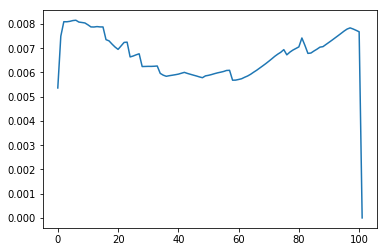

In [248]:
#plot graph of mean usage distribution

plt.plot(newList)
plt.show()

In [249]:
#K_S test to see if this vector comes from a normal distribution

#print(newList)
val =stats.kstest(newList, 'norm')
val

KstestResult(statistic=0.5, pvalue=0.0)